In [15]:
import numpy as np
import random
import gymnasium as gym
from gymnasium import spaces


In [16]:

class BudgetAllocationEnv(gym.Env):
    def __init__(self):
        super(BudgetAllocationEnv, self).__init__()
        
        # Define action and observation space
        # Actions: 0 = Increase, 1 = Maintain, 2 = Decrease
        self.action_space = spaces.Discrete(3)
        
        # States: (Channel 1 ROI, Channel 2 ROI)
        self.observation_space = spaces.MultiDiscrete([3, 3])  # 3 states for each channel
        
        # Initialize state
        self.state = (0, 0)  # Start with both channels at Low ROI
        
        # Rewards per state-action pair
        self.reward_matrix = {
            (0, 0, 0): -10,  # Low ROI for both, Increase (bad choice)
            (0, 0, 1): -5,   # Low ROI for both, Maintain (neutral choice)
            (0, 0, 2): 10,   # Low ROI for both, Decrease (good choice)
            (0, 1, 0): 20,   # Channel 1 Low, Channel 2 Moderate, Increase (good choice)
            (0, 1, 1): 5,    # Channel 1 Low, Channel 2 Moderate, Maintain (neutral choice)
            (0, 1, 2): -5,   # Channel 1 Low, Channel 2 Moderate, Decrease (bad choice)
            (0, 2, 0): -5,   # Channel 1 Low, Channel 2 High, Increase (bad choice)
            (0, 2, 1): 15,   # Channel 1 Low, Channel 2 High, Maintain (good choice)
            (0, 2, 2): -10,  # Channel 1 Low, Channel 2 High, Decrease (bad choice)
            (1, 0, 0): 20,   # Channel 1 Moderate, Channel 2 Low, Increase (good choice)
            (1, 0, 1): 5,    # Channel 1 Moderate, Channel 2 Low, Maintain (neutral choice)
            (1, 0, 2): -5,   # Channel 1 Moderate, Channel 2 Low, Decrease (bad choice)
            (1, 1, 0): 10,   # Moderate for both, Increase (neutral choice)
            (1, 1, 1): 5,    # Moderate for both, Maintain (neutral choice)
            (1, 1, 2): -5,   # Moderate for both, Decrease (bad choice)
            (1, 2, 0): -5,   # Channel 1 Moderate, Channel 2 High, Increase (bad choice)
            (1, 2, 1): 15,   # Channel 1 Moderate, Channel 2 High, Maintain (good choice)
            (1, 2, 2): -10,  # Channel 1 Moderate, Channel 2 High, Decrease (bad choice)
            (2, 0, 0): -5,   # Channel 1 High, Channel 2 Low, Increase (bad choice)
            (2, 0, 1): 15,   # Channel 1 High, Channel 2 Low, Maintain (good choice)
            (2, 0, 2): -10,  # Channel 1 High, Channel 2 Low, Decrease (bad choice)
            (2, 1, 0): -10,  # Channel 1 High, Channel 2 Moderate, Increase (bad choice)
            (2, 1, 1): 15,   # Channel 1 High, Channel 2 Moderate, Maintain (good choice)
            (2, 1, 2): -5,   # Channel 1 High, Channel 2 Moderate, Decrease (neutral choice)
            (2, 2, 0): -10,  # High ROI for both, Increase (bad choice)
            (2, 2, 1): 15,   # High ROI for both, Maintain (good choice)
            (2, 2, 2): -10   # High ROI for both, Decrease (bad choice)
        }
    
    def reset(self):
        # Reset to a random initial state (can be improved)
        self.state = (np.random.choice([0, 1, 2]), np.random.choice([0, 1, 2]))
        return self.state
    
    def step(self, action):
        channel_1_state, channel_2_state = self.state
        # Get reward based on current state and action
        reward = self.reward_matrix.get((channel_1_state, channel_2_state, action), 0)
        
        # Transition logic for channels based on action
        if action == 0:  # Increase
            if channel_1_state < 2:
                channel_1_state += 1
            if channel_2_state < 2:
                channel_2_state += 1
        elif action == 1:  # Maintain
            pass  # No change
        elif action == 2:  # Decrease
            if channel_1_state > 0:
                channel_1_state -= 1
            if channel_2_state > 0:
                channel_2_state -= 1
        
        # Check if the task is done (e.g., after 10 steps)
        done = np.random.rand() > 0.95  # Arbitrary condition for episode end
        
        # Update state
        self.state = (channel_1_state, channel_2_state)
        
        return self.state, reward, done, {}
    
    def render(self):
        state_names = ['Low ROI', 'Moderate ROI', 'High ROI']
        channel_1_state, channel_2_state = self.state
        print(f'Current State: Channel 1: {state_names[channel_1_state]}, Channel 2: {state_names[channel_2_state]}')


In [17]:

# Reinforcement Learning Framework Solution
def monte_carlo_learning(env, num_episodes=1000):
    Q_table = np.zeros((3, 3, 3))  # Three states for each of the two channels and three actions
    returns = { (s1, s2, a): [] for s1 in range(3) for s2 in range(3) for a in range(3) }  # Initialize returns

    for ep in range(num_episodes):
        episode = []
        state = env.reset()

        while True:
            action = env.action_space.sample()  # Choose an action randomly
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        # Process the episode to update the Q-values
        G = 0
        for t in range(len(episode) - 1, -1, -1):
            state, action, reward = episode[t]
            G = reward + 0.9 * G  # Discounted reward
            returns[(state[0], state[1], action)].append(G)  # Store returns
            Q_table[state[0], state[1], action] = np.mean(returns[(state[0], state[1], action)])  # Update Q-value

    return Q_table

In [18]:
# Create the environment and train the agent
env = BudgetAllocationEnv()
Q_table = monte_carlo_learning(env, num_episodes=1000)  # Train agent
print("Learned Q-table:")
print(Q_table)

Learned Q-table:
[[[ -7.49987995  -6.50827129   8.26316183]
  [ 21.37184208   6.56258279  -8.90220939]
  [ -2.9520118   18.64057014  -4.6828763 ]]

 [[ 23.98518223  12.53386914  -5.82550408]
  [  7.92715846   7.47167754  -6.70142169]
  [ -7.44494392  15.30552592  -5.14777153]]

 [[ -2.49573921  23.21283542  -2.32468002]
  [-13.2321615   21.18679027   5.41720221]
  [-11.77748357  12.87914612  -8.01820129]]]


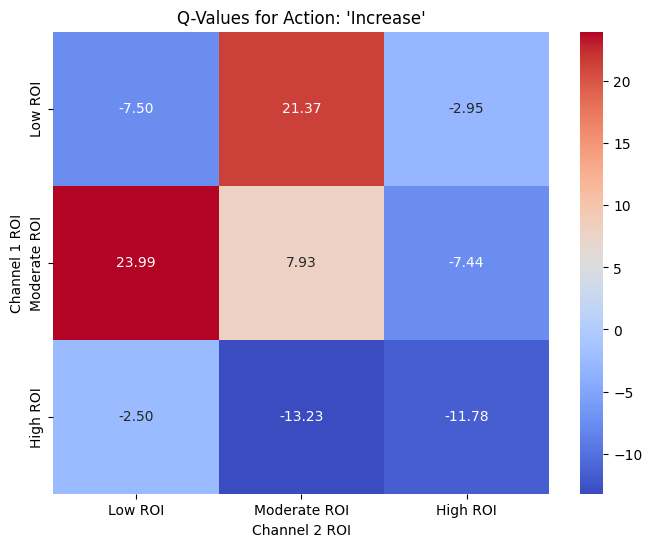

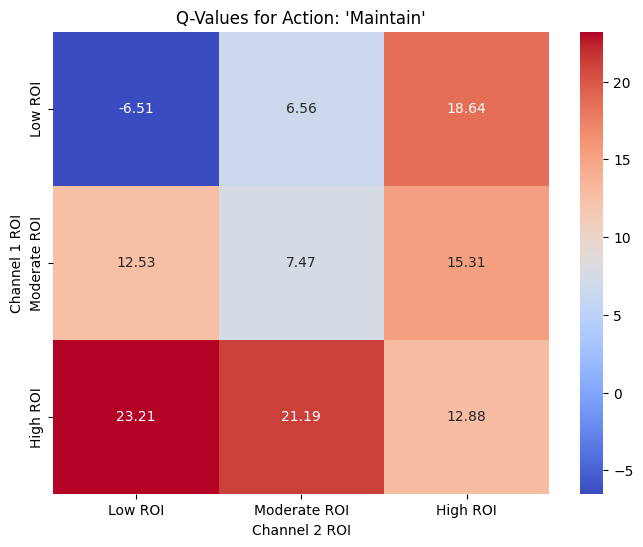

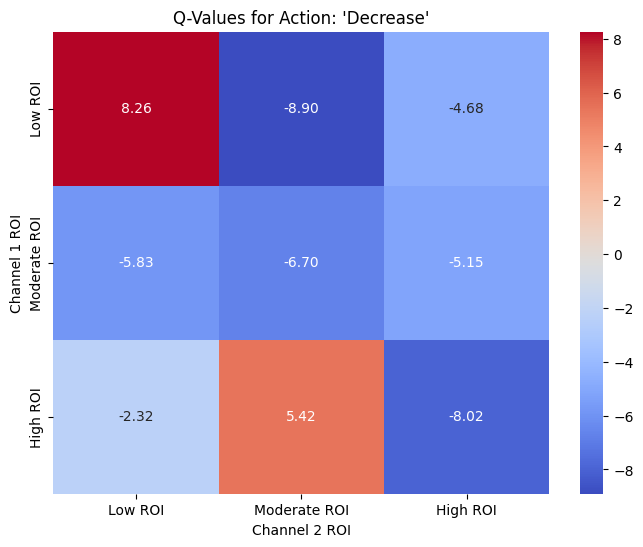

In [19]:
import matplotlib.pyplot as plt
import seaborn as snsQ_table = monte_carlo_learning(env, num_episodes=1000)  # Train agent
print("Learned Q-table:")
print(Q_table)

def plot_q_table(Q_table):
    state_names = ['Low ROI', 'Moderate ROI', 'High ROI']
    action_names = ['Increase', 'Maintain', 'Decrease']

    # Creating a heatmap for each action
    for action in range(3):
        plt.figure(figsize=(8, 6))
        sns.heatmap(Q_table[:, :, action], annot=True, fmt=".2f", cmap="coolwarm",
                    xticklabels=state_names, yticklabels=state_names)
        plt.title(f"Q-Values for Action: '{action_names[action]}'")
        plt.xlabel('Channel 2 ROI')
        plt.ylabel('Channel 1 ROI')
        plt.show()

# Call the plotting function
plot_q_table(Q_table)


In [40]:

class BudgetAllocationEnv(gym.Env):
    def __init__(self):
        super(BudgetAllocationEnv, self).__init__()
        self.action_space = gym.spaces.Discrete(3)  # Actions: 0 = Increase, 1 = Maintain, 2 = Decrease
        self.observation_space = gym.spaces.Discrete(3)  # States: 0 = Low ROI, 1 = Moderate ROI, 2 = High ROI
        self.state = 0
        
        # Rewards per state-action pair
        self.reward_matrix = {
            (0, 0): -10, (0, 1): -5, (0, 2): 10,  # Low ROI
            (1, 0): 20, (1, 1): 5, (1, 2): -5,   # Moderate ROI
            (2, 0): -5, (2, 1): 15, (2, 2): -10   # High ROI
        }
    
    def reset(self):
        self.state = np.random.choice([0, 1, 2])  # Reset to a random initial state
        return self.state
    
    def step(self, action):
        reward = self.reward_matrix.get((self.state, action), 0)
        
        # Transition logic
        if action == 0 and self.state < 2:
            next_state = self.state + 1
        elif action == 2 and self.state > 0:
            next_state = self.state - 1
        else:
            next_state = self.state
        
        done = np.random.rand() > 0.95  # Random episode end condition
        self.state = next_state
        return next_state, reward, done, {}

    def render(self):
        state_names = ['Low ROI', 'Moderate ROI', 'High ROI']
        print(f'Current State: {state_names[self.state]}')


In [41]:
def monte_carlo(env, num_episodes=1000, gamma=0.9):
    Q_table = np.zeros((3, 3))  # Shape: (3 states, 3 actions)
    returns = { (state, action): [] for state in range(3) for action in range(3) }  # Track returns
    rewards = []
    
    for ep in range(num_episodes):
        state = env.reset()
        episode = []  # Store (state, action, reward) tuples
        total_reward = 0
        
        while True:
            action = env.action_space.sample()  # Random action (for simplicity)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))  # Store state-action-reward
            total_reward += reward
            
            state = next_state
            if done:
                break
        
        # Calculate returns for each state-action pair in the episode
        G = 0
        for state, action, reward in reversed(episode):
            G = reward + gamma * G  # Calculate discounted return
            returns[(state, action)].append(G)  # Append the return to the list for this state-action pair
            Q_table[state, action] = np.mean(returns[(state, action)])  # Update Q-value as the average of returns
            
        rewards.append(total_reward)
    
    return Q_table, rewards

In [42]:
def q_learning(env, num_episodes=1000, alpha=0.1, gamma=0.9, epsilon=0.1):
    Q_table = np.zeros((3, 3))  # Shape: (3 states, 3 actions)
    rewards = []
    
    for ep in range(num_episodes):
        state = env.reset()
        total_reward = 0
        
        while True:
            # Epsilon-greedy action selection
            if random.random() < epsilon:
                action = env.action_space.sample()  # Explore
            else:
                action = np.argmax(Q_table[state, :])  # Exploit

            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            
            # Update Q-table
            Q_table[state, action] += alpha * (reward + gamma * np.max(Q_table[next_state, :]) - Q_table[state, action])
            
            state = next_state
            if done:
                break
        
        rewards.append(total_reward)
    
    return Q_table, rewards

def sarsa(env, num_episodes=1000, alpha=0.1, gamma=0.9, epsilon=0.1):
    Q_table = np.zeros((3, 3))  # Shape: (3 states, 3 actions)
    rewards = []
    
    for ep in range(num_episodes):
        state = env.reset()
        action = env.action_space.sample() if random.random() < epsilon else np.argmax(Q_table[state, :])
        total_reward = 0
        
        while True:
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            
            next_action = env.action_space.sample() if random.random() < epsilon else np.argmax(Q_table[next_state, :])
            
            # Update Q-table
            Q_table[state, action] += alpha * (reward + gamma * Q_table[next_state, next_action] - Q_table[state, action])
            
            state, action = next_state, next_action
            
            if done:
                break
        
        rewards.append(total_reward)
    
    return Q_table, rewards


In [43]:
# Create environment
env = BudgetAllocationEnv()

# Run Q-Learning and SARSA
num_episodes = 1000
mc_table, mc_rewards = monte_carlo(env, num_episodes)
q_table, q_rewards = q_learning(env, num_episodes)
sarsa_table, sarsa_rewards = sarsa(env, num_episodes)

# Display Q-tables
print("\nQ-Table from Monte Carlo:")
print(mc_table)

print("Q-Table from Q-Learning:")
print(q_table)

print("\nQ-Table from SARSA:")
print(sarsa_table)


Q-Table from Monte Carlo:
[[ 4.54087827  1.00895313 16.40053038]
 [29.60887078 19.76005518  1.30334056]
 [ 5.03128381 24.14500049  4.4498018 ]]
Q-Table from Q-Learning:
[[129.5         88.58170379  93.4663096 ]
 [155.         139.4689034  109.76778112]
 [130.         150.         129.5       ]]

Q-Table from SARSA:
[[118.4425036   74.99319976  78.16269183]
 [141.44835114 130.21711587  88.31472464]
 [117.29568642 136.22971544 118.82066223]]


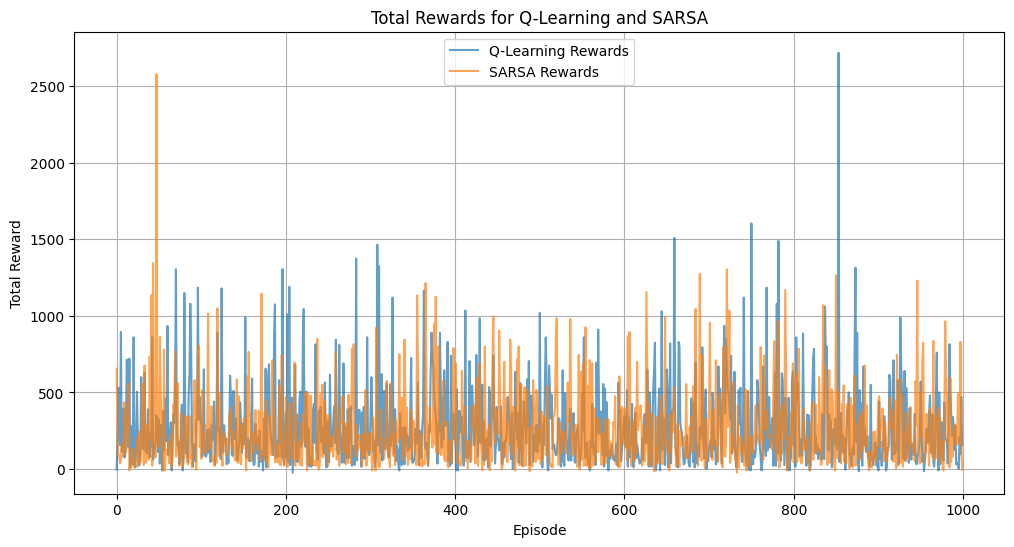

In [44]:
# Plot the total rewards
plt.figure(figsize=(12, 6))
plt.plot(np.arange(num_episodes), np.array(q_rewards), label='Q-Learning Rewards', alpha=0.7)
plt.plot(np.arange(num_episodes), np.array(sarsa_rewards), label='SARSA Rewards', alpha=0.7)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Rewards for Q-Learning and SARSA')
plt.legend()
plt.grid()
plt.show()